In [1]:
import json
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute, QuantumRegister, ClassicalRegister, Aer
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder
from gnn import ExpValCircuitGraphModel

In [28]:
backend = FakeMontreal()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(backend) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [38]:
def construct_tiling(circ_to_append, qbs_with_gates, num_qubit):
    """The circuit to append must already be measured"""
    assert len(qbs_with_gates) <= num_qubit
    idle_ind = list(set(range(num_qubit)) - set(qbs_with_gates))
    qr = QuantumRegister(num_qubit)
    cr = ClassicalRegister(num_qubit)
    qc = QuantumCircuit(qr, cr)
    qc.append(circ_to_append, qbs_with_gates, qbs_with_gates)
    qc.measure(idle_ind, idle_ind)
    return qc

In [54]:
qbs_with_gates = [0, 1, 2, 3] #list(range(8))
num_qubit = 4
circ_to_append = random_circuit(len(qbs_with_gates), 10, 2, measure=True)
qc = construct_tiling(circ_to_append, qbs_with_gates, num_qubit)

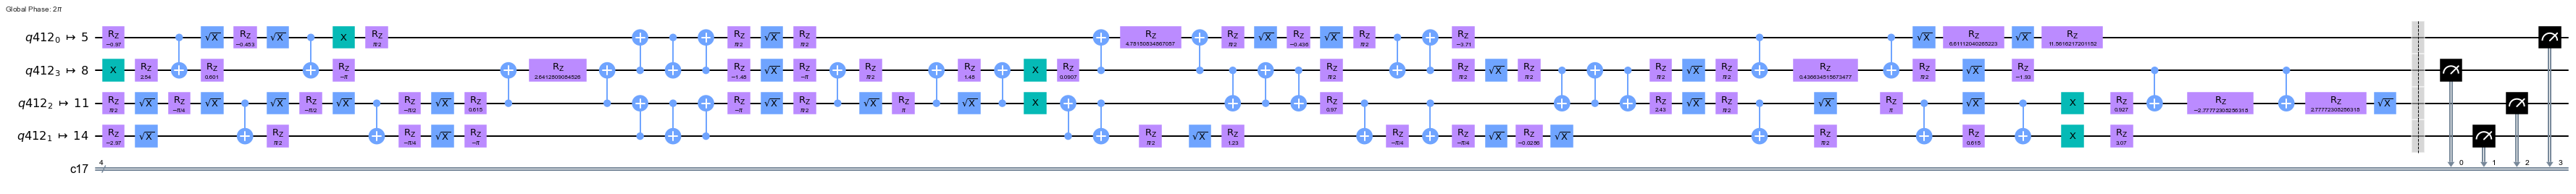

In [56]:
qc = transpile(qc, backend=backend_noisy, optimization_level=3)
qc.draw('mpl', fold=-1, idle_wires=False)

# Tiling Data Generation

In [6]:
def construct_mbl_tiling_circuit(qbs_with_gates, total_circuit_size, seed):
    num_spins = len(qbs_with_gates) # Number of spins. Must be even.
    assert num_spins <= total_circuit_size
    W = 0.8 * np.pi # Disorder strength up to np.pi
    theta = 0.05 * np.pi # Interaction strength up to np.pi
    steps = 6

    disorders = generate_disorder(num_spins, W, seed=seed)
    random_mbl_circuit = construct_mbl_circuit(num_spins, disorders, theta, steps)
    qc = construct_tiling(random_mbl_circuit, qbs_with_gates, total_circuit_size)
    qc = transpile(qc, backend=backend_noisy, optimization_level=3)
    return qc, random_mbl_circuit

In [7]:
qc, random_mbl = construct_mbl_tiling_circuit(list(range(8)), 8, 0)
random_mbl.draw(fold=-1, idle_wires=False, plot_barriers=True)

┌───────────────┐┌────────────┐                                   ┌───────────────┐┌────────────┐                                   ┌───────────────┐┌────────────┐                                   ┌───────────────┐┌────────────┐                                   ┌───────────────┐┌────────────┐                                   ┌───────────────┐┌────────────┐                                 ░ ┌─┐                     
   q_0: ──────■─┤ U3(π/20,0,-π) ├┤ P(0.24536) ├─────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(0.24536) ├─────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(0.24536) ├─────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(0.24536) ├─────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(0.24536) ├─────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(0.24536) ├─────────────────────────────────░─┤M├─────────────────────
        ┌───┐ │ ├───────────────┤└────────────┘┌───────────────┐ ┌───────────┐  │ ├───────────────┤└────────────┘┌───────────────┐ ┌───────────┐  │ ├───────────────┤└────────────┘┌───────────────┐ ┌───────────┐  │ ├───────────────┤└────────────┘┌───────────────┐ ┌───────────┐  │ ├───────────────┤└────────────┘┌───────────────┐ ┌───────────┐  │ ├───────────────┤└────────────┘┌───────────────┐ ┌───────────┐  ░ └╥┘┌─┐                  
   q_1: ┤ X ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(1.0817) ├──■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(1.0817) ├──■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(1.0817) ├──■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(1.0817) ├──■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(1.0817) ├──■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(1.0817) ├──░──╫─┤M├──────────────────
        └───┘   ├───────────────┤      │       ├───────────────┤ ├───────────┴┐   ├───────────────┤      │       ├───────────────┤ ├───────────┴┐   ├───────────────┤      │       ├───────────────┤ ├───────────┴┐   ├───────────────┤      │       ├───────────────┤ ├───────────┴┐   ├───────────────┤      │       ├───────────────┤ ├───────────┴┐   ├───────────────┤      │       ├───────────────┤ ├───────────┴┐ ░  ║ └╥┘┌─┐               
   q_2: ──────■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.51655) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.51655) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.51655) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.51655) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.51655) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.51655) ├─░──╫──╫─┤M├───────────────
        ┌───┐ │ ├───────────────┤              ├───────────────┤ ├────────────┤ │ ├───────────────┤              ├───────────────┤ ├────────────┤ │ ├───────────────┤              ├───────────────┤ ├────────────┤ │ ├───────────────┤              ├───────────────┤ ├────────────┤ │ ├───────────────┤              ├───────────────┤ ├────────────┤ │ ├───────────────┤              ├───────────────┤ ├────────────┤ ░  ║  ║ └╥┘┌─┐            
   q_3: ┤ X ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.22561) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.22561) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.22561) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.22561) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.22561) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(0.22561) ├─░──╫──╫──╫─┤M├────────────
        └───┘   ├───────────────┤      │       ├───────────────┤┌┴────────────┤   ├───────────────┤      │       ├───────────────┤┌┴────────────┤   ├───────────────┤      │       ├───────────────┤┌┴────────────┤   ├───────────────┤      │       ├───────────────┤┌┴────────────┤   ├───────────────┤      │       ├───────────────┤┌┴────────────┤   ├───────────────┤      │       ├───────────────┤┌┴────────────┤ ░  ║  ║  ║ └╥┘┌─┐         
   q_4: ──────■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├┤ P(-0.38375) ├─■─┤

In [9]:
from qiskit.transpiler.exceptions import TranspilerError
from scipy.linalg import LinAlgError

def generate_data(qbs_with_gates, total_num_qubits, save_path: str, n_entries_per_file: int, seed):
    entries = []

    for i in tqdm_notebook(range(n_entries_per_file)):
        success = False
        while not success:
            try:
                circuit = construct_mbl_tiling_circuit(qbs_with_gates, total_num_qubits, seed=seed)[0]
                success = True
            except (LinAlgError, TranspilerError, np.linalg.LinAlgError) as e:
                print(f"Ran into an error:, {e}")

        job_ideal = execute(circuit, **run_config_ideal)
        job_noisy = execute(circuit, **run_config_noisy)

        counts_ideal = job_ideal.result().get_counts()
        counts_noisy = job_noisy.result().get_counts()

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)

        graph_data = circuit_to_graph_data_json(
            circuit=circuit,
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )

        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val.tolist(),
            noisy_exp_values=[noisy_exp_val.tolist()],
            circuit_depth=circuit.depth()
        )
        entries.append(entry.to_dict())

    path = f"{save_path}/step6_q{qbs_with_gates[0]}-q{qbs_with_gates[-1]}_total{total_num_qubits}_seed{seed}.json"
    with open(path, "w") as f:
        # pprint(entries)
        json.dump(entries, f)

In [25]:
qbs_with_gates = [0, 1, 2, 6] #[1, 2, 3, 4] #list(range(4)) #[0, 1, 2, 3]
total_num_qubits = 8
seed = 3
circuit, random_mbl = construct_mbl_tiling_circuit(qbs_with_gates, total_num_qubits, seed)
# generate_data(qbs_with_gates, total_num_qubits, './data/tiling/train', 1000, seed)

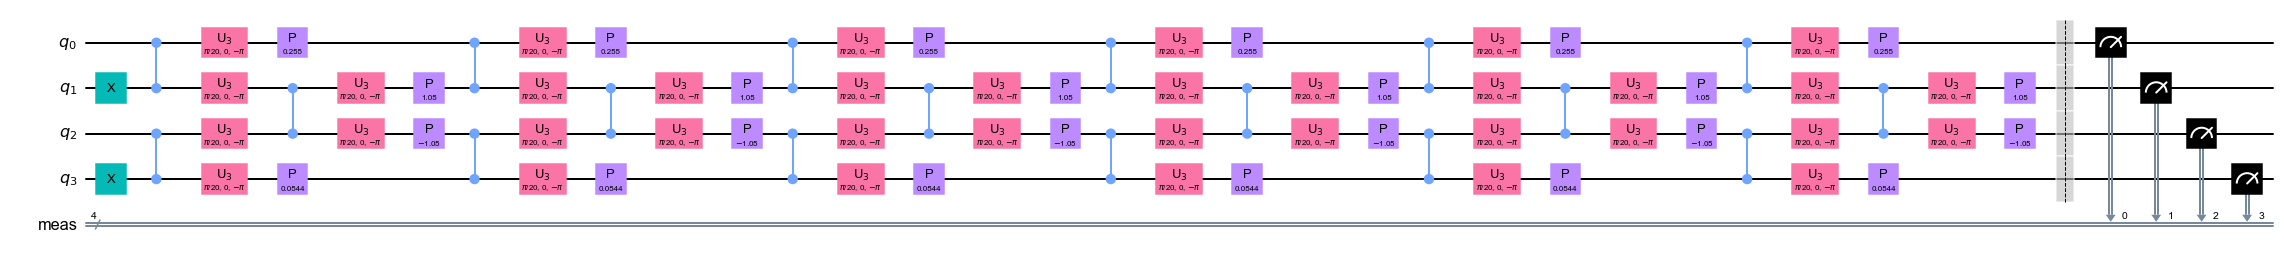

In [26]:
random_mbl.draw('mpl', fold=-1, idle_wires=False, plot_barriers=True)

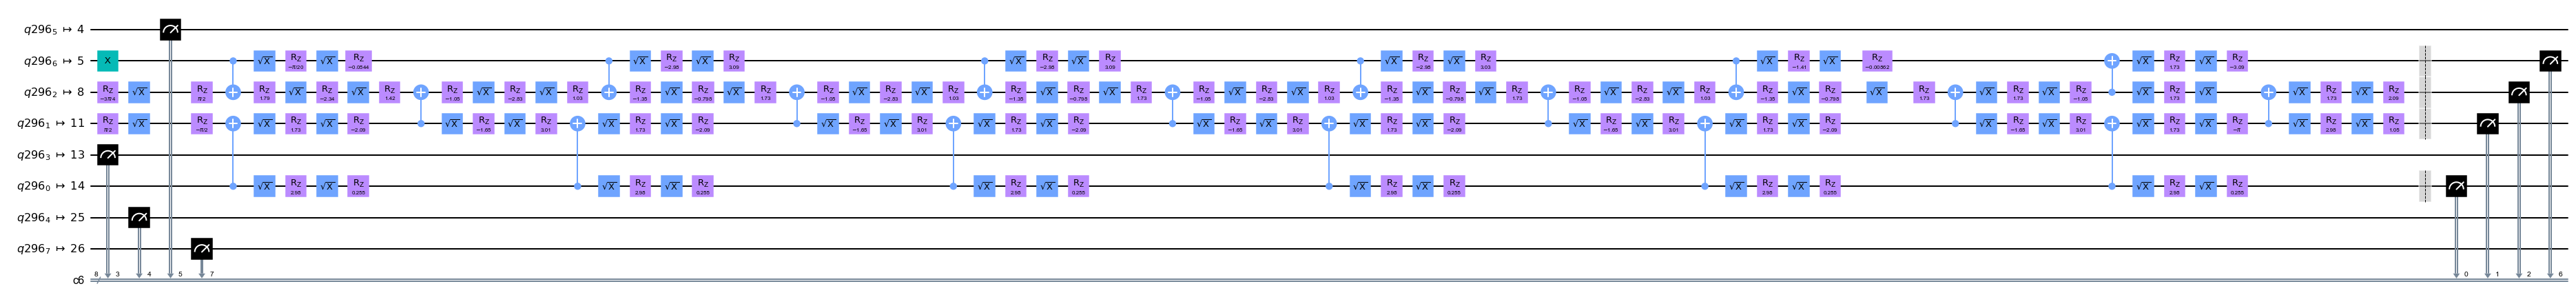

In [27]:
circuit.draw('mpl', fold=-1, idle_wires=False, plot_barriers=True)